In [66]:
import os
import sys
import numpy as np
#import pandas as pd
import cv2
import random
 

from PIL import Image, ImageOps
#from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from time import time
from pprint import pprint
from glob import glob
from importlib import import_module

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Subset
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from torch.optim.lr_scheduler import _LRScheduler

import math

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import wandb


In [67]:
name = "efficientnet-b1"  # 결과를 저장하는 폴더의 이름
batch_size = 128
lr = 2e-6
num_epochs = 12
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [68]:
def seed_everything(seed):
    """
    동일한 조건으로 학습을 할 때, 동일한 결과를 얻기 위해 seed를 고정시킵니다.
    
    Args:
        seed: seed 정수값
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
seed_everything(42)

In [69]:
num2class = ['normal', 'flip']


In [70]:
train_transform = A.Compose([
        A.Resize(128, 448, p=1.0),   
        A.Normalize(
            mean=(0.6162933558268724),
            std=(0.16278683017346854),
            max_pixel_value=255.0,
            p=1.0),
        A.OneOf([
            A.MotionBlur(p=1.0),
            A.Blur(p=1.0),
            A.GaussianBlur(p=1.0)
        ], p=0.1),
        ToTensorV2()
    ])
val_transform = A.Compose([
        A.Resize(128, 448, p=1.0),
        A.Normalize(
            mean=(0.6162933558268724),
            std=(0.16278683017346854),
            max_pixel_value=255.0,
            p=1.0),
        ToTensorV2()
    ])

In [71]:
cou = 0

In [72]:
class LoadDataset(Dataset):
    """Load Dataset"""
    def __init__(
        self,
        groundtruth,
        transform
    ):
        
        super(LoadDataset, self).__init__()
        self.transform = transform
        self.data = [
            {
                "path": p,
                "rotate": truth
            }
            for p, truth in groundtruth
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        item = self.data[i]
        image = Image.open(item["path"])
        image = image.convert("L")
        
        h, w = np.array(image).shape
        cou = 0
        if h > w*1.7:
            image = cv2.rotate(np.array(image), cv2.ROTATE_90_COUNTERCLOCKWISE)
            image_2 = cv2.rotate(np.array(image), cv2.ROTATE_90_COUNTERCLOCKWISE)
            image = Image.fromarray(image)
            cou = 1
        image_2 = 
        bounding_box = ImageOps.invert(image).getbbox()
        image = image.crop(bounding_box)

        # if self.transform:
        #     image = self.transform(image)
        # print("image type", type(image))

        if self.transform:
            transformed = self.transform(image=np.array(image))
            image = transformed["image"]
            image = image.float()

        return {"image": image, "rotate": item["rotate"], "bad": cou}

In [73]:
gt = "/opt/ml/input/data/train_dataset/gt.txt"

In [74]:
def split_gt_2(groundtruth, test_percent=None):
    root = os.path.join(os.path.dirname(groundtruth), "images")
    with open(groundtruth, "r") as fd:
        data = []
        for line in fd:
            data.append(line.strip().split("\t"))
        random.shuffle(data)
        data = [[os.path.join(root, x[0]), int(i%2 == 1)] for i, x in enumerate(data)]

        test_len = round(len(data) * test_percent)
        return data[test_len:], data[:test_len]
    

In [75]:
def split_gt(groundtruth, test_percent=None):
    root = os.path.join(os.path.dirname(groundtruth), "images")
    with open(groundtruth, "r") as fd:
        data = []
        for line in fd:
            data.append(line.strip().split("\t"))
        random.shuffle(data)
        data = [[os.path.join(root, x[0]), int(i%4)] for i, x in enumerate(data)]

        test_len = round(len(data) * test_percent)
        return data[test_len:], data[:test_len]
    

In [76]:
def classification_dataset_loader(batch_size, train_transformed, valid_transformed):
    train_data, valid_data = split_gt(gt, test_percent = 0.08)
    train_dataset = LoadDataset(
        train_data, transform=train_transformed
    )
    train_data_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
    )

    valid_dataset = LoadDataset(
        valid_data, transform=valid_transformed
    )
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
    )
    return train_data_loader, valid_data_loader


In [77]:
train_data_loader, valid_data_loader = classification_dataset_loader(batch_size,train_transform, val_transform )

In [78]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained("efficientnet-b1", num_classes=4)
model.to(device)
a = 2


Loaded pretrained weights for efficientnet-b1


In [79]:
class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)

    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]
    
    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [80]:
criterion = nn.CrossEntropyLoss() # 사용하는 Loss
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=5e-4) # 사용하는 Optimizer
lr_scheduler = CosineAnnealingWarmUpRestarts(
            optimizer,
            T_0=len(train_data_loader) * 20,
            T_mult=1,
            eta_max=5E-4,
            T_up=len(train_data_loader) * 1,
            gamma=0.3)

In [81]:
# for idx, train_batch in enumerate(train_data_loader):
#         inputs, labels = train_batch['image'], train_batch['rotate']
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         inputs[labels == 1, :, :, :] = torch.rot90(inputs[labels == 1, :, :, :], 2, [2, 3])
#         optimizer.zero_grad()
#         outs = model(torch.stack([inputs, inputs, inputs], dim=1).squeeze(2))
#         preds = torch.argmax(outs, dim=-1)
#         break

In [82]:
# wandb.init(project='rotate_classification', name='eff_b1')


In [83]:
os.makedirs(os.path.join(os.getcwd(), 'results', name), exist_ok=True)
train_log_interval = 50
counter = 0
best_val_acc = 0
best_val_loss = np.inf
for epoch in tqdm(range(num_epochs)):
    # train loop
    model.train()
    loss_value = 0
    matches = 0
    for idx, train_batch in enumerate(train_data_loader):
        inputs, labels = train_batch['image'], train_batch['rotate']
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs[labels == 1, :, :, :] = torch.rot90(inputs[labels == 1, :, :, :], 2, [2, 3])
        
        optimizer.zero_grad()

        outs = model(torch.stack([inputs, inputs, inputs], dim=1).squeeze(2))
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)
        wandb.log({'lr': optimizer.param_groups[0]['lr']})
        loss.backward()
        lr_scheduler.step()
        optimizer.step()
        
        # -- Gradient Accumulation
        # if (idx+1) % accumulation_steps == 0:
        #     optimizer.step()
        #     optimizer.zero_grad()

        loss_value += loss.item()
        matches += (preds == labels).sum().item()
        if (idx + 1) % train_log_interval == 0:
            train_loss = loss_value / train_log_interval
            train_acc = matches / batch_size / train_log_interval
            print(
                f"Epoch[{epoch}/{num_epochs}]({idx + 1}/{len(train_data_loader)}) || "
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} "
            )

            loss_value = 0
            matches = 0
            wandb.log({
                'epoch':  epoch + 1,
                'train/loss': train_loss,
                'train/acc': train_acc,
                })


    # val loop
    with torch.no_grad():
        print("Calculating validation results...")
        model.eval()
        val_loss_items = []
        val_acc_items = []
        for val_batch in valid_data_loader:
            inputs, labels = val_batch['image'], val_batch['rotate']
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs[labels == 1, :, :, :] = torch.rot90(inputs[labels == 1, :, :, :], 2, [2, 3])

            outs = model(torch.stack([inputs, inputs, inputs], dim=1).squeeze(2))
            preds = torch.argmax(outs, dim=-1)

            loss_item = criterion(outs, labels).item()
            acc_item = (labels == preds).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)

        val_loss = np.sum(val_loss_items) / len(valid_data_loader)
        val_acc = np.sum(val_acc_items) / len(valid_data_loader) / batch_size
        
        # Callback1: validation accuracy가 향상될수록 모델을 저장합니다.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        if val_acc > best_val_acc:
            print("New best model for val accuracy! saving the model..")
            torch.save(model.state_dict(), f"results/{name}/{epoch:03}_accuracy_{val_acc:4.2%}.ckpt")
            best_val_acc = val_acc
            counter = 0
        else:
            counter += 1
        # Callback2: patience 횟수 동안 성능 향상이 없을 경우 학습을 종료시킵니다.
        
        wandb.log({
                'val/loss': val_acc,
                'val/acc': val_loss,
                })
        
        print(
            f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
            f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
        )

  0%|          | 0/12 [00:00<?, ?it/s]

Error: You must call wandb.init() before wandb.log()

In [ ]:
save_path = os.path.join("/opt/ml/code/results/efficientnet-b1/009_accuracy_97.71%.ckpt")
model.load_state_dict(torch.load(save_path))
print(f"성공적으로 불러옴 {save_path}")

In [47]:
with torch.no_grad():
    model.eval()
    bad = []
    bad_normal = []
    bad_rotate = []
    for val_batch in tqdm(valid_data_loader):
        inputs, labels = val_batch['image'], val_batch['rotate']
        inputs = inputs.to(device)
        tem = inputs
        labels = labels.to(device)
        inputs[labels == 1, :, :, :] = torch.rot90(inputs[labels == 1, :, :, :], 2, [2, 3])

        outs = model(torch.stack([inputs, inputs, inputs], dim=1).squeeze(2))
        preds = torch.argmax(outs, dim=-1)

        bad_normal += [i for i, (x, y )in enumerate(zip(labels == preds, labels)) if not x and y==0]
        bad_rotate += [i for i, (x, y )in enumerate(zip(labels == preds, labels)) if not x and y==1]

    
    

  0%|          | 0/79 [00:00<?, ?it/s]

In [52]:
len(bad_normal)/len(valid_data_loader) / batch_size * 200

1.4636075949367089

In [53]:
len(bad_rotate)/len(valid_data_loader) / batch_size * 200

0.9098101265822784

In [24]:
labels == 1

tensor([False,  True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True],

In [35]:
c = [1,2,3]
c += b
c

[1, 2, 3, 30, 114]

In [26]:
inputs.shape

torch.Size([128, 1, 128, 448])

In [19]:
import PIL
import torchvision.transforms as transforms

In [20]:
tf = transforms.ToPILImage()

tensor(0, device='cuda:0') tensor(1, device='cuda:0')


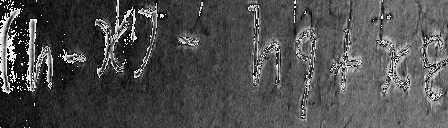

In [21]:
a = 30
print(labels[a] , preds[a])
tf(tem[a].cpu())

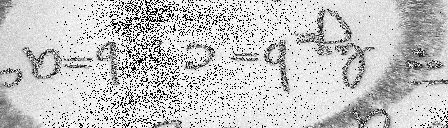

In [47]:
tf(inputs[11].cpu())

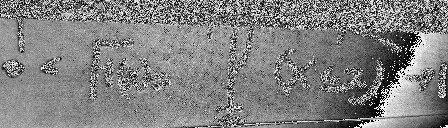

In [33]:
img